In [1]:
# -*- coding: utf-8 -*-
import sys, os
import numpy as np
import pandas as pd
import cobra

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)


Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0


In [2]:
def AddRxn(model: cobra.Model,
           newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model


In [3]:
def KORxn(model: cobra.Model,
          rxns2KO: list):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()


In [4]:
def pfba(model: cobra.Model):
    cobra.flux_analysis.pfba(model)
    print(model.summary())


In [5]:
def change_objective(model, product):
    """change objective function"""
    if product in ['accoa_c', 'succoa_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'coa_c': 1})
    elif product in ['g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', '3pg_c', 'pep_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'pi_c': 1})
    elif f"EX_{product}" not in model.reactions:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1})
    model.objective = f"EX_{product}"


In [6]:
def flux2file(model: cobra.Model, 
              psw, product, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                      columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                      'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(psw, product))
    df.to_excel(filepath, index=False)

In [7]:
def prodFBA(model, psw, product,saveif):
    solution = model.optimize()
    # print("%s: " %product, round(solution.objective_value, 3))
    # export results
    if saveif: 
        flux2file(model, psw, product)
    return round(solution.objective_value, 3)

 ## Model background

  * Using _E. coli_ full model iML1515.
  * Corrected the transhydrogenase (THD2pp) to one proton translocation.
  * Corrected homoserine dehydrogenase to be irreversible, towards homoserine.
  * Changed MMM (Methylmalonyl-CoA mutase) to be reversible.
  * FolD is reversible, MTHFC and MTHFD.
  * FTL reaction is existed, FTHFLi (irrversible)
  * The model has part of the Ethylmalonyl-CoA pathway, ACACT1r, HACD1 and ECOAH1,
  propanoyl-CoA degradation, MMM and MMCD already.
  * The model has DHAPT: dha_c + pep_c → dhap_c + pyr_c, then DAK might be not necessary;
 and F6PA: f6p_c ⇌ dha_c + g3p_c, which seems to be not active in vivo. PTAr.

In [8]:
model = cobra.io.load_json_model(r'..\..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.MMM.bounds = (-1000, 1000)


 ## Base knock-outs
 * pyruvate synthase (POR5), 3pg producing glycerate kinase (GLYCK)
 * aerobic: PFL, OBTFL, FRD2, FRD3
 * FDH4pp, FDH5pp, GART,
 * ATPM
 * the reactions for unrealistic AcCoA production DRPA & PAI2T
 *

In [9]:
KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp', 'ATPM',
              'PFL', 'OBTFL', 'GART', 'DRPA', 'PAI2T',
              'FRD2','FRD3','F6PA']

KORxn(model, KORxn_base)


In [10]:
# Set medium: formaldehyde as sole the carbon source.
for rxn in model.boundary:
    if "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0.0, 1000)
model.reactions.get_by_id('EX_co2_e').bounds = (-1000, 1000)
model.reactions.get_by_id('EX_fald_e').bounds = (-10, 0)

model.reactions.get_by_id('EX_h2s_e').bounds = (0.0, 0.0) # avoid using S as electron accepeter
model.reactions.get_by_id('EX_fe3_e').bounds = (0.0, 0.0) # avoid using Fe2 as electron donor


In [11]:
psws = {
    'RuMP': 'NewRxns4Full_RuMP.csv',
    'XuMP': 'NewRxns4Full_XuMP.csv',
    'SerCyc': 'NewRxns4Full_SerCyc.csv',
    'EuMP': 'NewRxns4Full_EuMP.csv',
}
# Serine cycle has ethylmalonyl-coa pathway reactions (EtMaCoA)


 ### Production of biomass and the 12 precursors (DOI: 10.1016/j.cell.2016.02.004)

In [12]:
precursors = ['biomass', 'g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', 
              '3pg_c', 'pep_c', 'pyr_c', 'accoa_c', 'akg_c', 
              'succoa_c', 'oaa_c']


In [13]:
# saveif = True
saveif = False
precursors_results = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model:
        _model = AddRxn(model, pswrxns)
        if psw == 'SerCyc':
            AddKO = ['THRA', 'THRD', 'EtMaCoA']  # no EtMaCoA to be fair
        else:
            AddKO = ['FTHFLi', 'THRA', 'THRD',]
        KORxn(_model, AddKO)
        for precursor in precursors:
            with _model:
                if precursor != 'biomass':
                    change_objective(_model, precursor)
                sol = prodFBA(_model, psw, precursor, saveif)
                precursors_results.loc[precursor, psw] = sol

precursors_results

unknown metabolite 'h6p_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'lEu1P_c' created
unknown metabolite 'dEu4P_c' created


,RuMP,XuMP,SerCyc,EuMP
biomass,0.150,0.134,0.106,0.150
g6p_c,1.599,1.373,0.986,1.599
f6p_c,1.599,1.373,0.986,1.599
e4p_c,2.350,2.059,1.479,2.350
r5p_c,1.903,1.647,1.183,1.903
g3p_c,3.072,2.745,1.972,3.072
3pg_c,3.333,3.333,2.295,3.333
pep_c,3.333,3.333,2.295,3.333
pyr_c,3.333,3.333,2.456,3.333
accoa_c,3.333,3.333,3.415,3.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


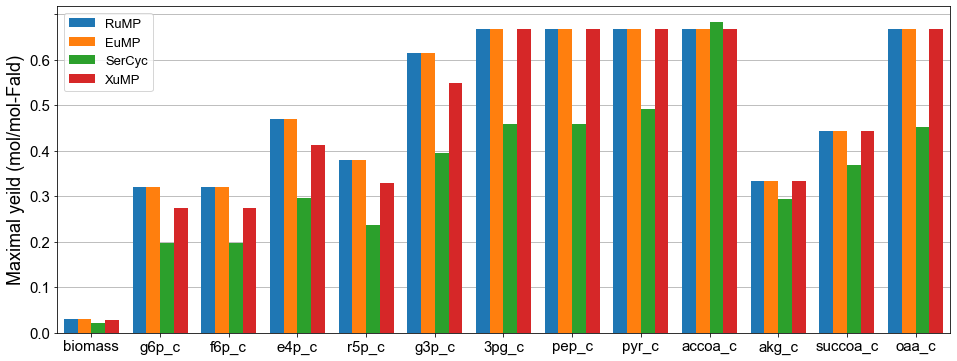

In [14]:
import matplotlib.pyplot as plt 

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['savefig.bbox'] = 'tight'

x = np.arange(len(precursors))
witdh = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xticks(x)
ax.set_xlim(-0.5, 12.5)
ax.set_xticklabels(precursors)
ax.set_yticklabels(map(str, np.arange(0, 7, 1)/10))
ax.set_ylabel('Maximal yeild (mol/mol-Fald)')
plt.grid(which='both', axis='y')
ax.bar(x-1.5*witdh, precursors_results['RuMP'], witdh, label='RuMP')
ax.bar(x-0.5*witdh, precursors_results['EuMP'], witdh, label = 'EuMP')
ax.bar(x+0.5*witdh, precursors_results['SerCyc'], witdh, label = 'SerCyc')
ax.bar(x+1.5*witdh, precursors_results['XuMP'], witdh, label = 'XuMP')
plt.legend()
plt.savefig('12 precursors production figure.eps', dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


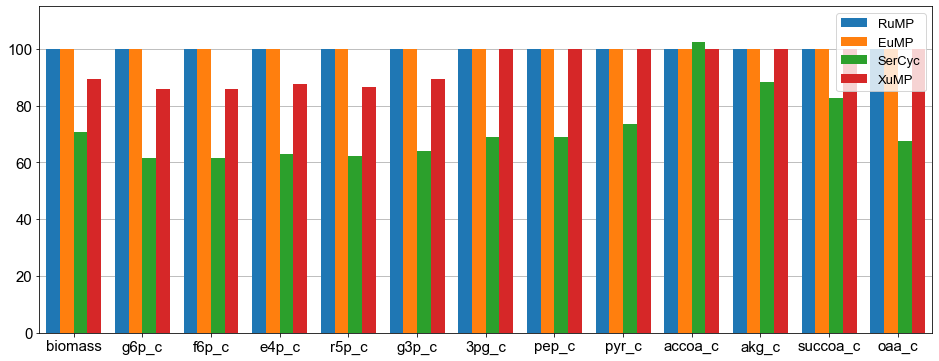

In [15]:
# yield of RuMP as 100%
yield_norm = precursors_results.div(precursors_results.RuMP, axis=0) * 100
round(yield_norm,1)

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xticks(x)
ax.set_xlim(-0.5, 12.5)
ax.set_xticklabels(precursors)  
ax.set_ylim(0, 115)
ax.set_ylabel('')
plt.grid(which='both', axis='y')
ax.bar(x-1.5*witdh, yield_norm['RuMP'], witdh, label='RuMP',)
ax.bar(x-0.5*witdh, yield_norm['EuMP'], witdh, label = 'EuMP',)
ax.bar(x+0.5*witdh, yield_norm['SerCyc'], witdh, label = 'SerCyc',)
ax.bar(x+1.5*witdh, yield_norm['XuMP'], witdh, label = 'XuMP',)
plt.legend()
plt.savefig('production comparison figure.eps', dpi=300)
plt.show()


 ### To calculation selection pressures
 Constraint biomass to be (1,1),
 model the minimal requirement of EPS flux

 ### ${\Delta}$frmRAB ${\Delta}$tktAB strain
 To confirm the strain does not grow on glycerol alone

In [16]:
model_m = model.copy()
eump_m = AddRxn(model_m, 'NewRxns4Full_EuMP.csv')
# KO DHAPT to block f6p -> dha -> dhap for better interpretation 
eump_m.reactions.DHAPT.knock_out()


unknown metabolite 'lEu1P_c' created
unknown metabolite 'dEu4P_c' created


In [17]:
with eump_m as m: 
    m.reactions.EX_glyc_e.lower_bound = -10
    m.reactions.EX_fald_e.lower_bound = 0
    KORxn(m,['TKT1','TKT2',])
    pfba(m)
    # flux2file(m,'EuMP','1_tkt')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []



In [18]:
with eump_m as m: 
    m.reactions.EX_glyc_e.lower_bound = -1000
    m.reactions.EX_fald_e.lower_bound = -1000
    KORxn(m,['TKT1','TKT2',])
    m.reactions.BIOMASS_Ec_iML1515_core_75p37M.bounds = (1,1)
    m.objective = {m.reactions.EPS: 1}
    m.objective_direction = 'min'
    pfba(m)
    flux2file(m,'EuMP','2_tkt')
    f_TKT = m.reactions.EPS.flux


Objective
1.0 EPS = 0.3806730000000002

Uptake
------
Metabolite     Reaction     Flux  C-Number C-Flux
     ca2_e     EX_ca2_e 0.005205         0  0.00%
      cl_e      EX_cl_e 0.005205         0  0.00%
 cobalt2_e EX_cobalt2_e  2.5E-05         0  0.00%
     cu2_e     EX_cu2_e 0.000709         0  0.00%
    fald_e    EX_fald_e   0.3807         1  0.65%
     fe2_e     EX_fe2_e  0.01606         0  0.00%
    glyc_e    EX_glyc_e    19.46         3 99.35%
       k_e       EX_k_e   0.1952         0  0.00%
     mg2_e     EX_mg2_e 0.008675         0  0.00%
     mn2_e     EX_mn2_e 0.000691         0  0.00%
    mobd_e    EX_mobd_e    7E-06         0  0.00%
     nh4_e     EX_nh4_e     10.8         0  0.00%
     ni2_e     EX_ni2_e 0.000323         0  0.00%
      o2_e      EX_o2_e    24.13         0  0.00%
      pi_e      EX_pi_e   0.9646         0  0.00%
     so4_e     EX_so4_e   0.2518         0  0.00%
     zn2_e     EX_zn2_e 0.000341         0  0.00%

Secretion
---------
Metabolite    Reaction   

 ### ${\Delta}$frmRAB ${\Delta}$fbp ${\Delta}$glpX strain
 Confirm the selection first

In [19]:
with eump_m as m: 
    m.reactions.EX_glyc_e.lower_bound = -10
    m.reactions.EX_fald_e.lower_bound = 0
    KORxn(m,['FBP',])
    pfba(m)
    # flux2file(m,'EuMP','3_fbp')


Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []



In [20]:
with eump_m as m: 
    m.reactions.EX_glyc_e.lower_bound = -1000
    m.reactions.EX_fald_e.lower_bound = -1000
    KORxn(m,['FBP',])
    m.reactions.BIOMASS_Ec_iML1515_core_75p37M.bounds = (1,1)
    m.objective = {m.reactions.EPS: 1}
    m.objective_direction = 'min'
    pfba(m)
    flux2file(m,'EuMP','4_fbp')
    f_FBP = m.reactions.EPS.flux


Objective
1.0 EPS = 2.6104330000000364

Uptake
------
Metabolite     Reaction     Flux  C-Number C-Flux
     ca2_e     EX_ca2_e 0.005205         0  0.00%
      cl_e      EX_cl_e 0.005205         0  0.00%
 cobalt2_e EX_cobalt2_e  2.5E-05         0  0.00%
     cu2_e     EX_cu2_e 0.000709         0  0.00%
    fald_e    EX_fald_e     2.61         1  4.45%
     fe2_e     EX_fe2_e  0.01606         0  0.00%
    glyc_e    EX_glyc_e     18.7         3 95.55%
       k_e       EX_k_e   0.1952         0  0.00%
     mg2_e     EX_mg2_e 0.008675         0  0.00%
     mn2_e     EX_mn2_e 0.000691         0  0.00%
    mobd_e    EX_mobd_e    7E-06         0  0.00%
     nh4_e     EX_nh4_e     10.8         0  0.00%
     ni2_e     EX_ni2_e 0.000323         0  0.00%
      o2_e      EX_o2_e    23.71         0  0.00%
      pi_e      EX_pi_e   0.9646         0  0.00%
     so4_e     EX_so4_e   0.2518         0  0.00%
     zn2_e     EX_zn2_e 0.000341         0  0.00%

Secretion
---------
Metabolite    Reaction   